## 사용 라이브러리

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Confusion Matrix func

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, y_pred=None, pred_prob=None, show_cm=0):
    confusion = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, pred_prob)
    if show_cm:
        print(f"정확도: {acc:.4f}\n정밀도: {precision:.4f}\n재현율: {recall:.4f}\nF1: {f1:.4f}\nROC_AUC: {roc_auc:.4f}")
    else:
        print(confusion)
        print(f"정확도: {acc:.4f}\n정밀도: {precision:.4f}\n재현율: {recall:.4f}\nF1: {f1:.4f}\nROC_AUC: {roc_auc:.4f}")
    return confusion, acc, precision, recall, f1, roc_auc

## Data Load

In [27]:
card_df = pd.read_csv("creditcard.csv")

In [4]:
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


## EDA & 전처리

In [5]:
card_df.isnull().sum().sum()

0

label 컬럼에서 카드 사기건수가 매우 낮은 것을 확인할 수 있음. 즉, 매우 불균형한 자료

0    284315
1       492
Name: Class, dtype: int64

<AxesSubplot:>

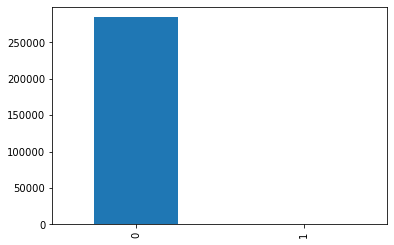

In [6]:
display(card_df.iloc[:,-1].value_counts())
display(card_df.iloc[:,-1].value_counts().plot(kind='bar'))

In [7]:
card_df.drop(columns="Time", axis=1, inplace=True)

label = card_df.iloc[:, -1]
features = card_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (199364, 29)
y_train: (199364,)
X_test: (85443, 29)
y_test: (85443,)


거의 98%가 사기가 아니고, 고작 2%만 사기 : 데이터가 엄청나게 불균형함

In [8]:
y_train.value_counts()/y_train.shape[0]*100

0    99.827451
1     0.172549
Name: Class, dtype: float64

## 모델 학습 및 평가

In [9]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    


lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[[85286     9]
 [   31   117]]
정확도: 0.9995
정밀도: 0.9286
재현율: 0.7905
F1: 0.8540
ROC_AUC: 0.9818


## EDA

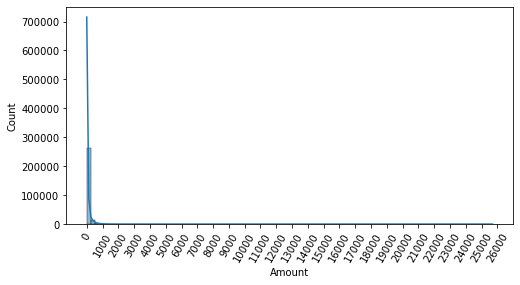

In [10]:
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [11]:
scaler = StandardScaler()
amount_n = scaler.fit_transform(card_df["Amount"].values.reshape(-1, 1))
card_df["Amount"] = amount_n

label = card_df.iloc[:, -1]
features = card_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (199364, 29)
y_train: (199364,)
X_test: (85443, 29)
y_test: (85443,)


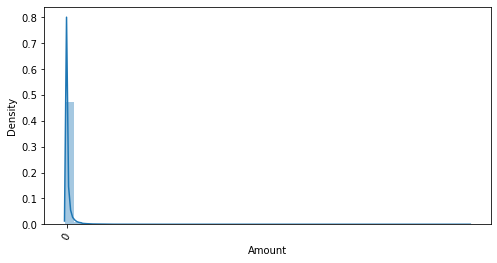

In [12]:
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
_ = sns.distplot(card_df["Amount"])

In [13]:
clf_lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(clf_lgbm, X_train, X_test, y_train, y_test)

[[85287     8]
 [   28   120]]
정확도: 0.9996
정밀도: 0.9375
재현율: 0.8108
F1: 0.8696
ROC_AUC: 0.9854


In [14]:
card_df = pd.read_csv("creditcard.csv")

amount_n = np.log1p(card_df["Amount"])
card_df.drop(columns="Time", axis=1, inplace=True)
card_df["Amount"] = amount_n

label = card_df.iloc[:, -1]
features = card_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (199364, 29)
y_train: (199364,)
X_test: (85443, 29)
y_test: (85443,)


데이터가 skew 되어있으므로 표준화를 위해 로그 변환을 진행

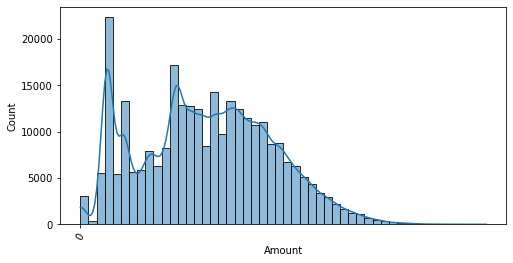

In [15]:
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
_ = sns.histplot(card_df["Amount"], bins = 50, kde=True)

## 모델 학습 및 평가

In [16]:
clf_lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(clf_lgbm, X_train, X_test, y_train, y_test)

[[85289     6]
 [   25   123]]
정확도: 0.9996
정밀도: 0.9535
재현율: 0.8311
F1: 0.8881
ROC_AUC: 0.9841


## 이상치 제거

<AxesSubplot:>

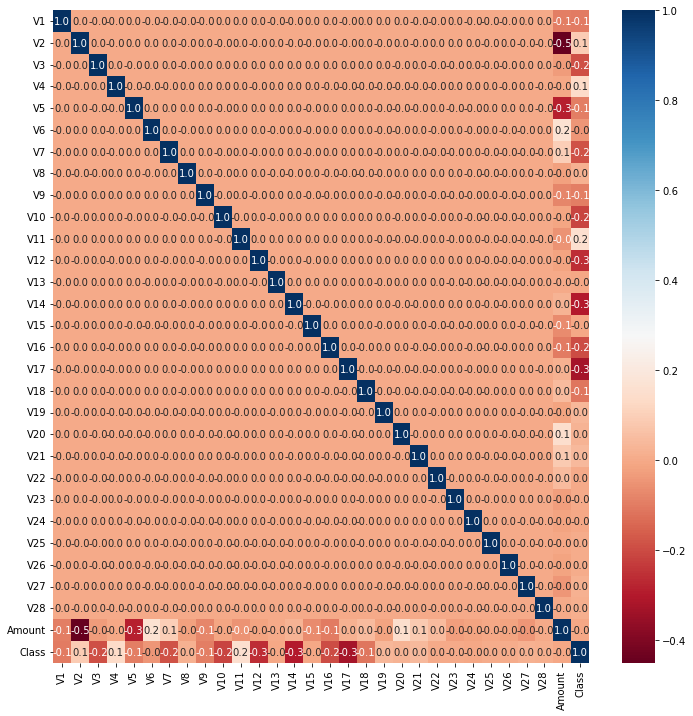

In [17]:
plt.figure(figsize=(12, 12))
corr = card_df.corr()
sns.heatmap(corr, annot=True, fmt='.1f',  cmap='RdBu')

V14, V17, V10, V12가 0과 1을 구분할 수 있는 중요한 컬럼임을 알 수 윘음

Text(0.5, 1.0, 'V14 vs Class')

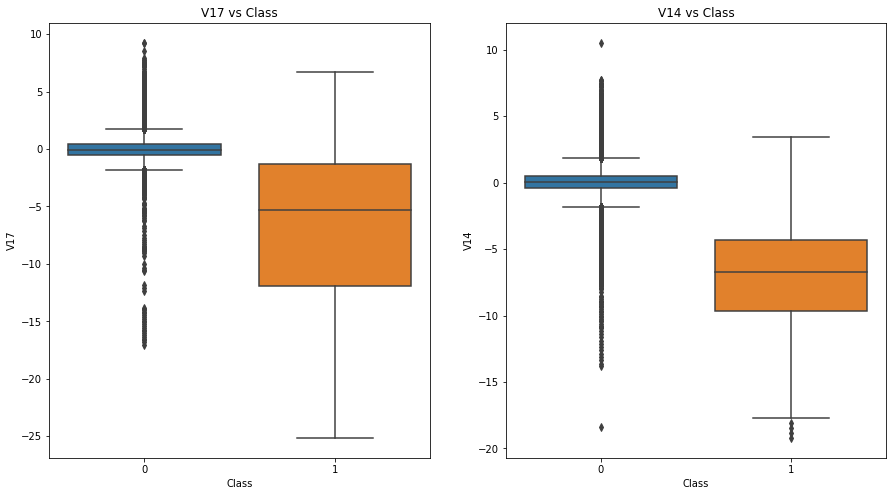

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))

sns.boxplot(x="Class", y="V17", data=card_df, ax=axes[0])
axes[0].set_title('V17 vs Class')

sns.boxplot(x="Class", y="V14", data=card_df, ax=axes[1])
axes[1].set_title('V14 vs Class')

Text(0.5, 1.0, 'V12 vs Class')

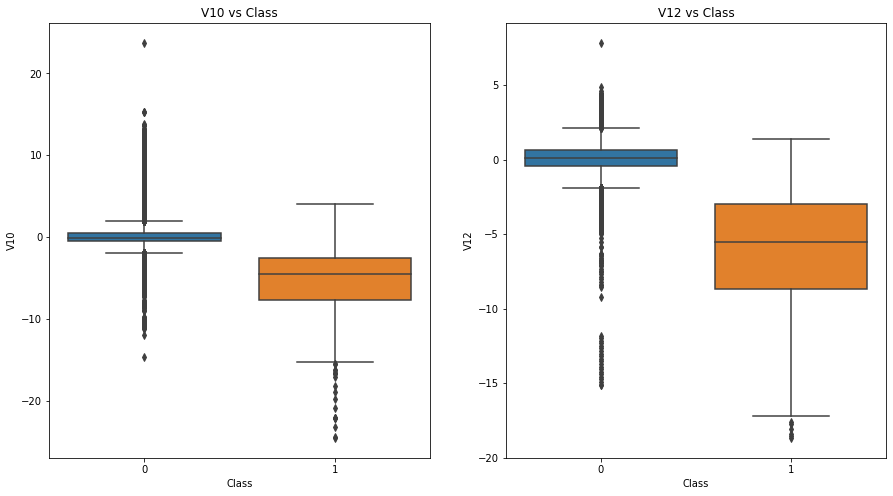

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))

sns.boxplot(x="Class", y="V10", data=card_df, ax=axes[0])
axes[0].set_title('V10 vs Class')

sns.boxplot(x="Class", y="V12", data=card_df, ax=axes[1])
axes[1].set_title('V12 vs Class')

그에 비해 V20과 V21은 연관이 거의 없음을 확인할 수 있음

Text(0.5, 1.0, 'V21 vs Class')

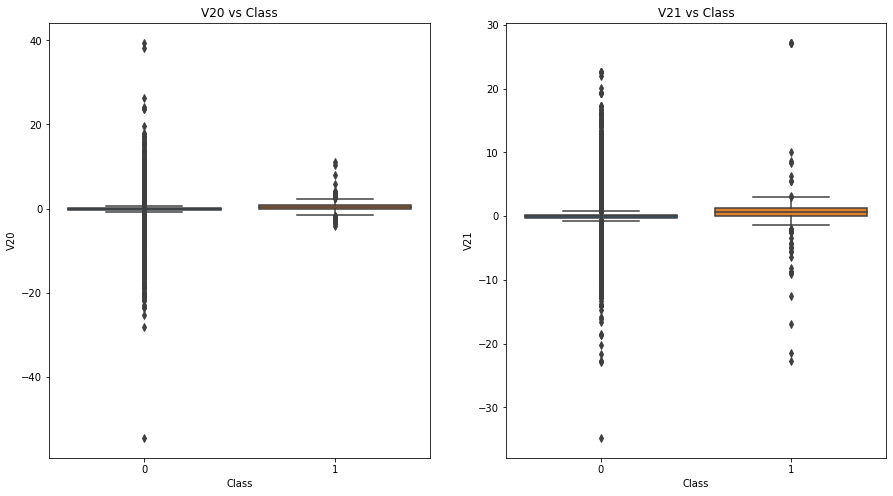

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))

sns.boxplot(x="Class", y="V20", data=card_df, ax=axes[0])
axes[0].set_title('V20 vs Class')

sns.boxplot(x="Class", y="V21", data=card_df, ax=axes[1])
axes[1].set_title('V21 vs Class')

이상치를 제거

In [21]:
def get_outlier(df=None, col=None, weight=1.5):
    fraud = df[df["Class"]==1][col]
    q25 = np.percentile(fraud.values, 25)
    q75 = np.percentile(fraud.values, 75)
    iqr = q75-q25
    iqr_weight = iqr*weight
    lowest_val = q25 - iqr_weight
    higest_val = q75 + iqr_weight
    outlier_index = fraud[(fraud<lowest_val) | (fraud>higest_val)].index
    return outlier_index

In [22]:
out_list = ["V10", "V12", "V14", "V17"]
out_list_index = []

for o in out_list:
    out_list_index.append(get_outlier(card_df, o, weight=1.5))

In [23]:
out_to_del = {key:val for key, val in zip(out_list, out_list_index)}

In [24]:
card_df = pd.read_csv("creditcard.csv")

amount_n = np.log1p(card_df["Amount"])
card_df.drop(columns="Time", axis=1, inplace=True)
for _ in range(0, len(out_list_index)):
    card_df.drop(_, axis=0, inplace=True, errors="ignore")
card_df["Amount"] = amount_n

label = card_df.iloc[:, -1]
features = card_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (199362, 29)
y_train: (199362,)
X_test: (85441, 29)
y_test: (85441,)


평가

In [25]:
clf_lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(clf_lgbm, X_train, X_test, y_train, y_test)

[[85284     9]
 [   28   120]]
정확도: 0.9996
정밀도: 0.9302
재현율: 0.8108
F1: 0.8664
ROC_AUC: 0.9870
